In [1]:
%tensorflow_version 1.X

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [3]:
!git clone https://github.com/openaifab/suicide_multiclass.git

Cloning into 'suicide_multiclass'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (31/31), done.


In [4]:
%cd suicide_multiclass
%pwd

/content/suicide_multiclass


'/content/suicide_multiclass'

## Import libraries

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

tensorflow version :  1.15.2
tensorflow_hub version :  0.8.0



## Load the data

   ID                                        Description  Class
0   0  最近又把自己蜷縮起來了不想吃不想動好想消失...沒有社會化的我連狗狗都有點社會化不足都兩歲了...      2
1   1  我想已經沒有意義了活著的動力每一天每一天不論在做什麼不論做的好壞一律歸零一切都是爛我整個人生...      2
2   2  因為身心狀況的關係把論文停掉 打算延畢除了指導老師  其他朋友我都沒說昨晚笑笑地跟室友說我買...      2
3   3  可能因為去年流了太多眼淚，又一直失眠拼命讓自己很忙很累才能閉上眼睡著眼睛很少休息所以左眼出了...      2
4   4  到底為什麼週日總會失眠？明明週一要早起為了這個嶄新的開始我最喜歡的禮拜一也應該早睡的可是就是...      2
**************************************************
各風險則數: 
高風險: 121 則
中風險: 180 則
低風險: 657 則
總共: 958 則


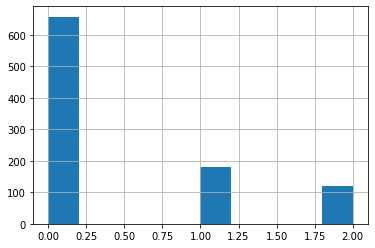

In [7]:
# Set the output directory for saving model file
OUTPUT_DIR = 'model'

data_source = "data/suicide3_train_1000.csv"

data_df = pd.read_csv(data_source, encoding='utf8', delimiter=',')
print(data_df.head())

print("*"*50)
print("各風險則數: ")
data_df['Class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

In [8]:
train, val =  train_test_split(data_df, test_size = 0.1, random_state = 100)

In [9]:
#Training set sample
print(train.head())

print("#"*100)
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

print("#"*100)
print("high risk train: ",train[train['Class'] == 2].shape[0])
print("medium risk train: ",train[train['Class'] == 1].shape[0])
print("low risk train: ",train[train['Class'] == 0].shape[0])

print("high risk val: ",val[val['Class'] == 2].shape[0])
print("medium risk val: ",val[val['Class'] == 1].shape[0])
print("low risk val: ",val[val['Class'] == 0].shape[0])

      ID                                        Description  Class
133  134  我知道，他將要來襲，我無法控制，調整呼吸也阻止不了，聽了音樂也無法，我真的好累，我為什麼這樣...      1
288  289  就還是兩星期前的餘波過不去就是過不去可見這件事程度之嚴重又暴走而且一次比一次嚴重連環爆越爆越...      0
805  806  在三總做完了十次的rtms其實也沒有像醫生說的這麼好睡但睡眠藥是減少了一些（我目前對贊安諾，...      0
265  266  大家好，被診斷為憂鬱症以來約有4個月了，病情稱不上改善也好像沒有惡化，但工作中不時出現坐在電...      0
791  792  XX很難進去，篩選的很嚴格幸運的進去了，也很認真的在上課與複習以為可以領稍微高薪一點的薪水但...      0
####################################################################################################
Training Set Shape : (862, 3)
Validation Set Shape : (96, 3)
####################################################################################################
high risk train:  108
medium risk train:  156
low risk train:  598
high risk val:  13
medium risk val:  24
low risk val:  59


In [10]:
DATA_COLUMN = 'Description'
LABEL_COLUMN = 'Class'
# The list containing all the classes
label_list = [0, 1, 2]

## Data preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

guid : A unique id that represents an observation.  
text_a : The text we need to classify into given categories  
text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.  
label: It consists of the labels or classes or categories that a given text belongs to.  
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.

In [11]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [12]:
train_InputExamples

133    <bert.run_classifier.InputExample object at 0x...
288    <bert.run_classifier.InputExample object at 0x...
805    <bert.run_classifier.InputExample object at 0x...
265    <bert.run_classifier.InputExample object at 0x...
791    <bert.run_classifier.InputExample object at 0x...
                             ...                        
855    <bert.run_classifier.InputExample object at 0x...
871    <bert.run_classifier.InputExample object at 0x...
835    <bert.run_classifier.InputExample object at 0x...
792    <bert.run_classifier.InputExample object at 0x...
520    <bert.run_classifier.InputExample object at 0x...
Length: 862, dtype: object

In [13]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  我知道，他將要來襲，我無法控制，調整呼吸也阻止不了，聽了音樂也無法，我真的好累，我為什麼這樣子，想大聲呼喚。其實我勇敢說出來了一點，可是沒人想聽，真的有夠絕望。一邊還要顧及你那所謂的顏面，我只能在這裡暗自痛苦，無聲的呼喊。淚腺又失控了，惡性循環，很慶幸我還有這裡，我已經無處可躲

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  1


The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.  
check the model list here: https://tfhub.dev/s?network-architecture=transformer&publisher=google

In [14]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['我', '知', '道', '，', '他', '將', '要', '來', '襲', '，', '我', '無', '法', '控', '制', '，', '調', '整', '呼', '吸', '也', '阻', '止', '不', '了', '，', '聽', '了', '音', '樂', '也', '無', '法', '，', '我', '真', '的', '好', '累', '，', '我', '為', '什', '麼', '這', '樣', '子', '，', '想', '大', '聲', '呼', '喚', '。', '其', '實', '我', '勇', '敢', '說', '出', '來', '了', '一', '點', '，', '可', '是', '沒', '人', '想', '聽', '，', '真', '的', '有', '夠', '絕', '望', '。', '一', '邊', '還', '要', '顧', '及', '你', '那', '所', '謂', '的', '顏', '面', '，', '我', '只', '能', '在', '這', '裡', '暗', '自', '痛', '苦', '，', '無', '聲', '的', '呼', '喊', '。', '淚', '腺', '又', '失', '控', '了', '，', '惡', '性', '循', '環', '，', '很', '慶', '幸', '我', '還', '有', '這', '裡', '，', '我', '已', '經', '無', '處', '可', '躲']


Format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [16]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 256 #128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 862


INFO:tensorflow:Writing example 0 of 862


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 我 知 道 ， 他 將 要 來 襲 ， 我 無 法 控 制 ， 調 整 呼 吸 也 阻 止 不 了 ， 聽 了 音 樂 也 無 法 ， 我 真 的 好 累 ， 我 為 什 麼 這 樣 子 ， 想 大 聲 呼 喚 。 其 實 我 勇 敢 說 出 來 了 一 點 ， 可 是 沒 人 想 聽 ， 真 的 有 夠 絕 望 。 一 邊 還 要 顧 及 你 那 所 謂 的 顏 面 ， 我 只 能 在 這 裡 暗 自 痛 苦 ， 無 聲 的 呼 喊 。 淚 腺 又 失 控 了 ， 惡 性 循 環 ， 很 慶 幸 我 還 有 這 裡 ， 我 已 經 無 處 可 躲 [SEP]


INFO:tensorflow:tokens: [CLS] 我 知 道 ， 他 將 要 來 襲 ， 我 無 法 控 制 ， 調 整 呼 吸 也 阻 止 不 了 ， 聽 了 音 樂 也 無 法 ， 我 真 的 好 累 ， 我 為 什 麼 這 樣 子 ， 想 大 聲 呼 喚 。 其 實 我 勇 敢 說 出 來 了 一 點 ， 可 是 沒 人 想 聽 ， 真 的 有 夠 絕 望 。 一 邊 還 要 顧 及 你 那 所 謂 的 顏 面 ， 我 只 能 在 這 裡 暗 自 痛 苦 ， 無 聲 的 呼 喊 。 淚 腺 又 失 控 了 ， 惡 性 循 環 ， 很 慶 幸 我 還 有 這 裡 ， 我 已 經 無 處 可 躲 [SEP]


INFO:tensorflow:input_ids: 101 2769 4761 6887 8024 800 2200 6206 889 6204 8024 2769 4192 3791 2971 1169 8024 6310 3146 1461 1429 738 7349 3632 679 749 8024 5481 749 7509 3556 738 4192 3791 8024 2769 4696 4638 1962 5168 8024 2769 4158 784 7938 6857 3564 2094 8024 2682 1920 5476 1461 1598 511 1071 2179 2769 1235 3140 6303 1139 889 749 671 7953 8024 1377 3221 3760 782 2682 5481 8024 4696 4638 3300 1917 5179 3307 511 671 6920 6917 6206 7547 1350 872 6929 2792 6333 4638 7542 7481 8024 2769 1372 5543 1762 6857 6174 3266 5632 4578 5736 8024 4192 5476 4638 1461 1591 511 3907 5593 1348 1927 2971 749 8024 2670 2595 2542 4472 8024 2523 2723 2401 2769 6917 3300 6857 6174 8024 2769 2347 5195 4192 5993 1377 6719 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2769 4761 6887 8024 800 2200 6206 889 6204 8024 2769 4192 3791 2971 1169 8024 6310 3146 1461 1429 738 7349 3632 679 749 8024 5481 749 7509 3556 738 4192 3791 8024 2769 4696 4638 1962 5168 8024 2769 4158 784 7938 6857 3564 2094 8024 2682 1920 5476 1461 1598 511 1071 2179 2769 1235 3140 6303 1139 889 749 671 7953 8024 1377 3221 3760 782 2682 5481 8024 4696 4638 3300 1917 5179 3307 511 671 6920 6917 6206 7547 1350 872 6929 2792 6333 4638 7542 7481 8024 2769 1372 5543 1762 6857 6174 3266 5632 4578 5736 8024 4192 5476 4638 1461 1591 511 3907 5593 1348 1927 2971 749 8024 2670 2595 2542 4472 8024 2523 2723 2401 2769 6917 3300 6857 6174 8024 2769 2347 5195 4192 5993 1377 6719 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 就 還 是 兩 星 期 前 的 餘 波 過 不 去 就 是 過 不 去 可 見 這 件 事 程 度 之 嚴 重 又 暴 走 而 且 一 次 比 一 次 嚴 重 連 環 爆 越 爆 越 大 這 樣 下 去 要 整 個 大 翻 桌 了 。 - - 謝 謝 ~ ~ 自 走 砲 會 一 直 想 去 炸 對 方 啊 ( 有 沒 有 什 麼 保 持 距 離 的 撇 步 [UNK] 謝 謝 c 大 謝 謝 : ) [SEP]


INFO:tensorflow:tokens: [CLS] 就 還 是 兩 星 期 前 的 餘 波 過 不 去 就 是 過 不 去 可 見 這 件 事 程 度 之 嚴 重 又 暴 走 而 且 一 次 比 一 次 嚴 重 連 環 爆 越 爆 越 大 這 樣 下 去 要 整 個 大 翻 桌 了 。 - - 謝 謝 ~ ~ 自 走 砲 會 一 直 想 去 炸 對 方 啊 ( 有 沒 有 什 麼 保 持 距 離 的 撇 步 [UNK] 謝 謝 c 大 謝 謝 : ) [SEP]


INFO:tensorflow:input_ids: 101 2218 6917 3221 1060 3215 3309 1184 4638 7626 3797 6882 679 1343 2218 3221 6882 679 1343 1377 6210 6857 816 752 4923 2428 722 1713 7028 1348 3274 6624 5445 684 671 3613 3683 671 3613 1713 7028 6865 4472 4255 6632 4255 6632 1920 6857 3564 678 1343 6206 3146 943 1920 5436 3430 749 511 118 118 6342 6342 172 172 5632 6624 4787 3298 671 4684 2682 1343 4156 2205 3175 1557 113 3300 3760 3300 784 7938 924 2898 6655 7431 4638 3050 3635 100 6342 6342 145 1920 6342 6342 131 114 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2218 6917 3221 1060 3215 3309 1184 4638 7626 3797 6882 679 1343 2218 3221 6882 679 1343 1377 6210 6857 816 752 4923 2428 722 1713 7028 1348 3274 6624 5445 684 671 3613 3683 671 3613 1713 7028 6865 4472 4255 6632 4255 6632 1920 6857 3564 678 1343 6206 3146 943 1920 5436 3430 749 511 118 118 6342 6342 172 172 5632 6624 4787 3298 671 4684 2682 1343 4156 2205 3175 1557 113 3300 3760 3300 784 7938 924 2898 6655 7431 4638 3050 3635 100 6342 6342 145 1920 6342 6342 131 114 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 在 三 總 做 完 了 十 次 的 rt ##ms 其 實 也 沒 有 像 醫 生 說 的 這 麼 好 睡 但 睡 眠 藥 是 減 少 了 一 些 （ 我 目 前 對 贊 安 諾 ， 戀 多 眠 和 史 蒂 諾 斯 都 完 全 無 感 ， 吃 十 幾 顆 也 一 樣 ， 所 以 只 好 吃 優 達 平 大 顆 ） 有 幾 天 好 像 有 點 活 力 了 起 來 有 幾 天 又 突 然 出 現 想 躲 起 來 的 感 覺 不 知 道 到 底 在 我 身 上 有 沒 有 效 ？ 好 討 厭 憂 鬱 好 討 厭 低 落 感 希 望 會 愈 來 愈 好 卻 又 有 點 沒 信 心 另 外 那 邊 可 以 找 病 友 聊 聊 呢 如 果 你 也 是 間 歇 憂 鬱 或 曾 經 重 度 憂 鬱 的 之 前 帳 號 重 設 群 組 都 被 退 了 . . . - - [SEP]


INFO:tensorflow:tokens: [CLS] 在 三 總 做 完 了 十 次 的 rt ##ms 其 實 也 沒 有 像 醫 生 說 的 這 麼 好 睡 但 睡 眠 藥 是 減 少 了 一 些 （ 我 目 前 對 贊 安 諾 ， 戀 多 眠 和 史 蒂 諾 斯 都 完 全 無 感 ， 吃 十 幾 顆 也 一 樣 ， 所 以 只 好 吃 優 達 平 大 顆 ） 有 幾 天 好 像 有 點 活 力 了 起 來 有 幾 天 又 突 然 出 現 想 躲 起 來 的 感 覺 不 知 道 到 底 在 我 身 上 有 沒 有 效 ？ 好 討 厭 憂 鬱 好 討 厭 低 落 感 希 望 會 愈 來 愈 好 卻 又 有 點 沒 信 心 另 外 那 邊 可 以 找 病 友 聊 聊 呢 如 果 你 也 是 間 歇 憂 鬱 或 曾 經 重 度 憂 鬱 的 之 前 帳 號 重 設 群 組 都 被 退 了 . . . - - [SEP]


INFO:tensorflow:input_ids: 101 1762 676 5244 976 2130 749 1282 3613 4638 10678 8884 1071 2179 738 3760 3300 1008 7015 4495 6303 4638 6857 7938 1962 4717 852 4717 4697 5973 3221 3938 2208 749 671 763 8020 2769 4680 1184 2205 6558 2128 6330 8024 2761 1914 4697 1469 1380 5881 6330 3172 6963 2130 1059 4192 2697 8024 1391 1282 2407 7538 738 671 3564 8024 2792 809 1372 1962 1391 1032 6888 2398 1920 7538 8021 3300 2407 1921 1962 1008 3300 7953 3833 1213 749 6629 889 3300 2407 1921 1348 4960 4197 1139 4412 2682 6719 6629 889 4638 2697 6221 679 4761 6887 1168 2419 1762 2769 6716 677 3300 3760 3300 3126 8043 1962 6245 1339 2726 7786 1962 6245 1339 856 5862 2697 2361 3307 3298 2689 889 2689 1962 1320 1348 3300 7953 3760 928 2552 1369 1912 6929 6920 1377 809 2823 4567 1351 5464 5464 1450 1963 3362 872 738 3221 7279 3623 2726 7786 2772 3295 5195 7028 2428 2726 7786 4638 722 1184 2379 5998 7028 6257 5408 5175 6963 6158 6842 749 119 119 119 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 1762 676 5244 976 2130 749 1282 3613 4638 10678 8884 1071 2179 738 3760 3300 1008 7015 4495 6303 4638 6857 7938 1962 4717 852 4717 4697 5973 3221 3938 2208 749 671 763 8020 2769 4680 1184 2205 6558 2128 6330 8024 2761 1914 4697 1469 1380 5881 6330 3172 6963 2130 1059 4192 2697 8024 1391 1282 2407 7538 738 671 3564 8024 2792 809 1372 1962 1391 1032 6888 2398 1920 7538 8021 3300 2407 1921 1962 1008 3300 7953 3833 1213 749 6629 889 3300 2407 1921 1348 4960 4197 1139 4412 2682 6719 6629 889 4638 2697 6221 679 4761 6887 1168 2419 1762 2769 6716 677 3300 3760 3300 3126 8043 1962 6245 1339 2726 7786 1962 6245 1339 856 5862 2697 2361 3307 3298 2689 889 2689 1962 1320 1348 3300 7953 3760 928 2552 1369 1912 6929 6920 1377 809 2823 4567 1351 5464 5464 1450 1963 3362 872 738 3221 7279 3623 2726 7786 2772 3295 5195 7028 2428 2726 7786 4638 722 1184 2379 5998 7028 6257 5408 5175 6963 6158 6842 749 119 119 119 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 大 家 好 ， 被 診 斷 為 憂 鬱 症 以 來 約 有 4 個 月 了 ， 病 情 稱 不 上 改 善 也 好 像 沒 有 惡 化 ， 但 工 作 中 不 時 出 現 坐 在 電 腦 前 但 煩 躁 至 極 ， 什 麼 都 不 想 做 、 連 一 根 手 指 都 抬 不 起 來 ， 茫 然 地 盯 著 螢 幕 看 的 情 況 。 過 年 前 想 著 離 職 但 到 現 在 也 沒 有 實 現 ， 想 著 會 不 會 是 因 為 在 病 情 的 低 潮 所 以 不 敢 急 著 做 決 定 ， 現 在 的 工 作 同 事 都 很 好 所 以 並 沒 有 人 際 上 的 問 題 ， 但 工 作 時 間 內 真 的 就 常 常 心 態 忽 然 崩 潰 。 不 知 道 大 家 都 是 怎 樣 的 契 機 決 定 的 呢 [UNK] [UNK] - - [SEP]


INFO:tensorflow:tokens: [CLS] 大 家 好 ， 被 診 斷 為 憂 鬱 症 以 來 約 有 4 個 月 了 ， 病 情 稱 不 上 改 善 也 好 像 沒 有 惡 化 ， 但 工 作 中 不 時 出 現 坐 在 電 腦 前 但 煩 躁 至 極 ， 什 麼 都 不 想 做 、 連 一 根 手 指 都 抬 不 起 來 ， 茫 然 地 盯 著 螢 幕 看 的 情 況 。 過 年 前 想 著 離 職 但 到 現 在 也 沒 有 實 現 ， 想 著 會 不 會 是 因 為 在 病 情 的 低 潮 所 以 不 敢 急 著 做 決 定 ， 現 在 的 工 作 同 事 都 很 好 所 以 並 沒 有 人 際 上 的 問 題 ， 但 工 作 時 間 內 真 的 就 常 常 心 態 忽 然 崩 潰 。 不 知 道 大 家 都 是 怎 樣 的 契 機 決 定 的 呢 [UNK] [UNK] - - [SEP]


INFO:tensorflow:input_ids: 101 1920 2157 1962 8024 6158 6262 3174 4158 2726 7786 4568 809 889 5147 3300 125 943 3299 749 8024 4567 2658 4935 679 677 3121 1587 738 1962 1008 3760 3300 2670 1265 8024 852 2339 868 704 679 3229 1139 4412 1777 1762 7442 5582 1184 852 4214 6708 5635 3513 8024 784 7938 6963 679 2682 976 510 6865 671 3418 2797 2900 6963 2848 679 6629 889 8024 5755 4197 1765 4681 5865 6086 2391 4692 4638 2658 3785 511 6882 2399 1184 2682 5865 7431 5480 852 1168 4412 1762 738 3760 3300 2179 4412 8024 2682 5865 3298 679 3298 3221 1728 4158 1762 4567 2658 4638 856 4060 2792 809 679 3140 2593 5865 976 3748 2137 8024 4412 1762 4638 2339 868 1398 752 6963 2523 1962 2792 809 699 3760 3300 782 7396 677 4638 1558 7539 8024 852 2339 868 3229 7279 1058 4696 4638 2218 2382 2382 2552 2706 2575 4197 2309 4061 511 679 4761 6887 1920 2157 6963 3221 2582 3564 4638 1943 3582 3748 2137 4638 1450 100 100 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 1920 2157 1962 8024 6158 6262 3174 4158 2726 7786 4568 809 889 5147 3300 125 943 3299 749 8024 4567 2658 4935 679 677 3121 1587 738 1962 1008 3760 3300 2670 1265 8024 852 2339 868 704 679 3229 1139 4412 1777 1762 7442 5582 1184 852 4214 6708 5635 3513 8024 784 7938 6963 679 2682 976 510 6865 671 3418 2797 2900 6963 2848 679 6629 889 8024 5755 4197 1765 4681 5865 6086 2391 4692 4638 2658 3785 511 6882 2399 1184 2682 5865 7431 5480 852 1168 4412 1762 738 3760 3300 2179 4412 8024 2682 5865 3298 679 3298 3221 1728 4158 1762 4567 2658 4638 856 4060 2792 809 679 3140 2593 5865 976 3748 2137 8024 4412 1762 4638 2339 868 1398 752 6963 2523 1962 2792 809 699 3760 3300 782 7396 677 4638 1558 7539 8024 852 2339 868 3229 7279 1058 4696 4638 2218 2382 2382 2552 2706 2575 4197 2309 4061 511 679 4761 6887 1920 2157 6963 3221 2582 3564 4638 1943 3582 3748 2137 4638 1450 100 100 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] [UNK] 很 難 進 去 ， 篩 選 的 很 嚴 格 幸 運 的 進 去 了 ， 也 很 認 真 的 在 上 課 與 複 習 以 為 可 以 領 稍 微 高 薪 一 點 的 薪 水 但 難 度 真 的 好 高 又 剛 好 很 衰 ， 模 式 更 改 了 直 接 下 分 到 各 組 別 第 一 天 就 馬 上 接 到 嚴 重 客 訴 的 ， 被 瘋 狂 咆 哮 與 罵 了 三 十 分 鐘 、 還 被 罵 王 八 蛋 但 我 一 點 感 覺 都 沒 有 ， 因 為 奧 客 見 多 了 。 但 卻 因 為 我 頻 繁 的 問 問 題 ， 小 老 師 開 始 不 耐 煩 口 氣 不 是 很 好 ， 我 玻 璃 心 碎 只 好 離 職 我 很 氣 她 也 很 不 甘 心 ， 我 們 才 下 線 第 五 天 耶 沒 有 耐 心 就 別 當 小 老 師 好 嗎 ? - - [SEP]


INFO:tensorflow:tokens: [CLS] [UNK] 很 難 進 去 ， 篩 選 的 很 嚴 格 幸 運 的 進 去 了 ， 也 很 認 真 的 在 上 課 與 複 習 以 為 可 以 領 稍 微 高 薪 一 點 的 薪 水 但 難 度 真 的 好 高 又 剛 好 很 衰 ， 模 式 更 改 了 直 接 下 分 到 各 組 別 第 一 天 就 馬 上 接 到 嚴 重 客 訴 的 ， 被 瘋 狂 咆 哮 與 罵 了 三 十 分 鐘 、 還 被 罵 王 八 蛋 但 我 一 點 感 覺 都 沒 有 ， 因 為 奧 客 見 多 了 。 但 卻 因 為 我 頻 繁 的 問 問 題 ， 小 老 師 開 始 不 耐 煩 口 氣 不 是 很 好 ， 我 玻 璃 心 碎 只 好 離 職 我 很 氣 她 也 很 不 甘 心 ， 我 們 才 下 線 第 五 天 耶 沒 有 耐 心 就 別 當 小 老 師 好 嗎 ? - - [SEP]


INFO:tensorflow:input_ids: 101 100 2523 7432 6868 1343 8024 5072 6908 4638 2523 1713 3419 2401 6880 4638 6868 1343 749 8024 738 2523 6291 4696 4638 1762 677 6307 5645 6185 5424 809 4158 1377 809 7526 4924 2544 7770 5959 671 7953 4638 5959 3717 852 7432 2428 4696 4638 1962 7770 1348 1190 1962 2523 6139 8024 3563 2466 3291 3121 749 4684 2970 678 1146 1168 1392 5175 1162 5018 671 1921 2218 7679 677 2970 1168 1713 7028 2145 6260 4638 8024 6158 4597 4312 1467 1527 5645 5393 749 676 1282 1146 7132 510 6917 6158 5393 4374 1061 6028 852 2769 671 7953 2697 6221 6963 3760 3300 8024 1728 4158 1953 2145 6210 1914 749 511 852 1320 1728 4158 2769 7536 5246 4638 1558 1558 7539 8024 2207 5439 2374 7274 1993 679 5447 4214 1366 3706 679 3221 2523 1962 8024 2769 4390 4461 2552 4810 1372 1962 7431 5480 2769 2523 3706 1961 738 2523 679 4491 2552 8024 2769 947 2798 678 5221 5018 758 1921 5456 3760 3300 5447 2552 2218 1162 4534 2207 5439 2374 1962 1621 136 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 100 2523 7432 6868 1343 8024 5072 6908 4638 2523 1713 3419 2401 6880 4638 6868 1343 749 8024 738 2523 6291 4696 4638 1762 677 6307 5645 6185 5424 809 4158 1377 809 7526 4924 2544 7770 5959 671 7953 4638 5959 3717 852 7432 2428 4696 4638 1962 7770 1348 1190 1962 2523 6139 8024 3563 2466 3291 3121 749 4684 2970 678 1146 1168 1392 5175 1162 5018 671 1921 2218 7679 677 2970 1168 1713 7028 2145 6260 4638 8024 6158 4597 4312 1467 1527 5645 5393 749 676 1282 1146 7132 510 6917 6158 5393 4374 1061 6028 852 2769 671 7953 2697 6221 6963 3760 3300 8024 1728 4158 1953 2145 6210 1914 749 511 852 1320 1728 4158 2769 7536 5246 4638 1558 1558 7539 8024 2207 5439 2374 7274 1993 679 5447 4214 1366 3706 679 3221 2523 1962 8024 2769 4390 4461 2552 4810 1372 1962 7431 5480 2769 2523 3706 1961 738 2523 679 4491 2552 8024 2769 947 2798 678 5221 5018 758 1921 5456 3760 3300 5447 2552 2218 1162 4534 2207 5439 2374 1962 1621 136 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 96


INFO:tensorflow:Writing example 0 of 96


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 要 害 怕 的 事 情 好 多 好 多 然 後 很 多 都 不 是 靠 我 本 身 的 意 志 力 就 能 解 決 的 肚 子 裡 的 生 命 來 到 21 週 我 卻 好 難 過 他 知 道 自 己 要 來 當 我 的 小 孩 嗎 他 以 後 會 不 會 恨 我 或 是 我 會 不 會 失 控 以 後 我 該 去 哪 裡 要 怎 麼 選 擇 好 難 好 難 現 在 有 沒 有 藥 可 以 救 救 我 稍 微 舒 緩 我 的 情 緒 會 不 會 是 因 此 小 孩 的 物 品 才 都 沒 買 因 為 也 沒 錢 買 不 生 出 來 可 憐 那 生 出 來 會 不 會 更 可 憐 - - [SEP]


INFO:tensorflow:tokens: [CLS] 要 害 怕 的 事 情 好 多 好 多 然 後 很 多 都 不 是 靠 我 本 身 的 意 志 力 就 能 解 決 的 肚 子 裡 的 生 命 來 到 21 週 我 卻 好 難 過 他 知 道 自 己 要 來 當 我 的 小 孩 嗎 他 以 後 會 不 會 恨 我 或 是 我 會 不 會 失 控 以 後 我 該 去 哪 裡 要 怎 麼 選 擇 好 難 好 難 現 在 有 沒 有 藥 可 以 救 救 我 稍 微 舒 緩 我 的 情 緒 會 不 會 是 因 此 小 孩 的 物 品 才 都 沒 買 因 為 也 沒 錢 買 不 生 出 來 可 憐 那 生 出 來 會 不 會 更 可 憐 - - [SEP]


INFO:tensorflow:input_ids: 101 6206 2154 2586 4638 752 2658 1962 1914 1962 1914 4197 2527 2523 1914 6963 679 3221 7479 2769 3315 6716 4638 2692 2562 1213 2218 5543 6237 3748 4638 5496 2094 6174 4638 4495 1462 889 1168 8128 6867 2769 1320 1962 7432 6882 800 4761 6887 5632 2346 6206 889 4534 2769 4638 2207 2111 1621 800 809 2527 3298 679 3298 2616 2769 2772 3221 2769 3298 679 3298 1927 2971 809 2527 2769 6283 1343 1525 6174 6206 2582 7938 6908 3079 1962 7432 1962 7432 4412 1762 3300 3760 3300 5973 1377 809 3131 3131 2769 4924 2544 5653 5227 2769 4638 2658 5219 3298 679 3298 3221 1728 3634 2207 2111 4638 4289 1501 2798 6963 3760 6525 1728 4158 738 3760 7092 6525 679 4495 1139 889 1377 2730 6929 4495 1139 889 3298 679 3298 3291 1377 2730 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6206 2154 2586 4638 752 2658 1962 1914 1962 1914 4197 2527 2523 1914 6963 679 3221 7479 2769 3315 6716 4638 2692 2562 1213 2218 5543 6237 3748 4638 5496 2094 6174 4638 4495 1462 889 1168 8128 6867 2769 1320 1962 7432 6882 800 4761 6887 5632 2346 6206 889 4534 2769 4638 2207 2111 1621 800 809 2527 3298 679 3298 2616 2769 2772 3221 2769 3298 679 3298 1927 2971 809 2527 2769 6283 1343 1525 6174 6206 2582 7938 6908 3079 1962 7432 1962 7432 4412 1762 3300 3760 3300 5973 1377 809 3131 3131 2769 4924 2544 5653 5227 2769 4638 2658 5219 3298 679 3298 3221 1728 3634 2207 2111 4638 4289 1501 2798 6963 3760 6525 1728 4158 738 3760 7092 6525 679 4495 1139 889 1377 2730 6929 4495 1139 889 3298 679 3298 3291 1377 2730 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 今 天 自 己 煮 飯 ， 水 煮 黃 豆 + 白 飯 + 煎 蛋 ， 但 還 是 熱 量 超 標 了 ( 吃 太 多 ) ， 而 且 睡 覺 前 還 是 好 餓 ! 為 了 理 想 體 重 要 忍 耐 ! 今 天 練 腿 ， 看 紀 錄 大 概 一 年 整 沒 練 了 ， 我 的 天 ! 希 望 明 天 還 有 辦 法 走 路 。 拖 了 一 整 天 ， 在 睡 前 還 是 努 力 讀 了 一 篇 英 文 ， 至 少 不 會 太 自 責 ， 距 離 目 標 還 是 遙 遠 ， 紀 錄 一 下 ， 希 望 可 以 一 步 一 步 越 來 越 進 步 。 今 天 心 情 好 一 點 了 ， 但 還 是 時 不 時 鼻 酸 ， 時 不 時 滑 著 手 機 尋 求 安 慰 。 加 油 吧 ， 晚 安 。 - - [SEP]


INFO:tensorflow:tokens: [CLS] 今 天 自 己 煮 飯 ， 水 煮 黃 豆 + 白 飯 + 煎 蛋 ， 但 還 是 熱 量 超 標 了 ( 吃 太 多 ) ， 而 且 睡 覺 前 還 是 好 餓 ! 為 了 理 想 體 重 要 忍 耐 ! 今 天 練 腿 ， 看 紀 錄 大 概 一 年 整 沒 練 了 ， 我 的 天 ! 希 望 明 天 還 有 辦 法 走 路 。 拖 了 一 整 天 ， 在 睡 前 還 是 努 力 讀 了 一 篇 英 文 ， 至 少 不 會 太 自 責 ， 距 離 目 標 還 是 遙 遠 ， 紀 錄 一 下 ， 希 望 可 以 一 步 一 步 越 來 越 進 步 。 今 天 心 情 好 一 點 了 ， 但 還 是 時 不 時 鼻 酸 ， 時 不 時 滑 著 手 機 尋 求 安 慰 。 加 油 吧 ， 晚 安 。 - - [SEP]


INFO:tensorflow:input_ids: 101 791 1921 5632 2346 4215 7613 8024 3717 4215 7941 6486 116 4635 7613 116 4203 6028 8024 852 6917 3221 4229 7030 6631 3560 749 113 1391 1922 1914 114 8024 5445 684 4717 6221 1184 6917 3221 1962 7625 106 4158 749 4415 2682 7768 7028 6206 2556 5447 106 791 1921 5230 5597 8024 4692 5145 7087 1920 3519 671 2399 3146 3760 5230 749 8024 2769 4638 1921 106 2361 3307 3209 1921 6917 3300 6794 3791 6624 6662 511 2870 749 671 3146 1921 8024 1762 4717 1184 6917 3221 1222 1213 6364 749 671 5063 5739 3152 8024 5635 2208 679 3298 1922 5632 6519 8024 6655 7431 4680 3560 6917 3221 6891 6895 8024 5145 7087 671 678 8024 2361 3307 1377 809 671 3635 671 3635 6632 889 6632 6868 3635 511 791 1921 2552 2658 1962 671 7953 749 8024 852 6917 3221 3229 679 3229 7965 7000 8024 3229 679 3229 3998 5865 2797 3582 2204 3724 2128 2720 511 1217 3779 1416 8024 3241 2128 511 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 791 1921 5632 2346 4215 7613 8024 3717 4215 7941 6486 116 4635 7613 116 4203 6028 8024 852 6917 3221 4229 7030 6631 3560 749 113 1391 1922 1914 114 8024 5445 684 4717 6221 1184 6917 3221 1962 7625 106 4158 749 4415 2682 7768 7028 6206 2556 5447 106 791 1921 5230 5597 8024 4692 5145 7087 1920 3519 671 2399 3146 3760 5230 749 8024 2769 4638 1921 106 2361 3307 3209 1921 6917 3300 6794 3791 6624 6662 511 2870 749 671 3146 1921 8024 1762 4717 1184 6917 3221 1222 1213 6364 749 671 5063 5739 3152 8024 5635 2208 679 3298 1922 5632 6519 8024 6655 7431 4680 3560 6917 3221 6891 6895 8024 5145 7087 671 678 8024 2361 3307 1377 809 671 3635 671 3635 6632 889 6632 6868 3635 511 791 1921 2552 2658 1962 671 7953 749 8024 852 6917 3221 3229 679 3229 7965 7000 8024 3229 679 3229 3998 5865 2797 3582 2204 3724 2128 2720 511 1217 3779 1416 8024 3241 2128 511 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 第 一 次 發 文 ， 是 重 鬱 症 的 我 服 藥 第 二 年 了 忽 然 有 機 會 跟 爸 爸 聊 天 ， 知 道 了 家 族 不 同 人 的 觀 點 ， 原 來 爸 爸 跟 我 一 樣 喜 歡 國 文 ， 原 來 他 當 過 講 師 ， 原 來 他 們 不 離 婚 是 因 為 責 任 感 諮 商 的 認 知 行 為 治 療 能 改 變 憂 鬱 嗎 ？ 醫 生 跟 我 說 ， 很 少 ， 藥 物 還 是 比 較 有 效 ， 懷 孕 了 也 可 以 吃 ， 不 用 擔 心 本 來 以 為 會 吃 一 輩 子 的 。 心 境 的 改 變 不 是 因 為 諮 商 ， 不 是 因 為 吃 藥 ， 就 是 因 為 一 個 偶 然 的 聊 天 ， 可 笑 中 帶 著 一 點 溫 暖 ， 還 是 不 知 道 自 己 會 不 會 離 開 憂 鬱 ， 我 的 放 假 日 白 天 來 到 了 公 園 ， 買 了 吐 司 跟 奶 茶 ， 看 到 了 幼 稚 園 小 朋 友 在 拍 畢 業 照 ， 高 中 生 在 寫 生 春 天 快 來 了 吧 ， 深 知 在 谷 底 的 無 力 感 ， 大 家 一 起 看 看 世 [SEP]


INFO:tensorflow:tokens: [CLS] 第 一 次 發 文 ， 是 重 鬱 症 的 我 服 藥 第 二 年 了 忽 然 有 機 會 跟 爸 爸 聊 天 ， 知 道 了 家 族 不 同 人 的 觀 點 ， 原 來 爸 爸 跟 我 一 樣 喜 歡 國 文 ， 原 來 他 當 過 講 師 ， 原 來 他 們 不 離 婚 是 因 為 責 任 感 諮 商 的 認 知 行 為 治 療 能 改 變 憂 鬱 嗎 ？ 醫 生 跟 我 說 ， 很 少 ， 藥 物 還 是 比 較 有 效 ， 懷 孕 了 也 可 以 吃 ， 不 用 擔 心 本 來 以 為 會 吃 一 輩 子 的 。 心 境 的 改 變 不 是 因 為 諮 商 ， 不 是 因 為 吃 藥 ， 就 是 因 為 一 個 偶 然 的 聊 天 ， 可 笑 中 帶 著 一 點 溫 暖 ， 還 是 不 知 道 自 己 會 不 會 離 開 憂 鬱 ， 我 的 放 假 日 白 天 來 到 了 公 園 ， 買 了 吐 司 跟 奶 茶 ， 看 到 了 幼 稚 園 小 朋 友 在 拍 畢 業 照 ， 高 中 生 在 寫 生 春 天 快 來 了 吧 ， 深 知 在 谷 底 的 無 力 感 ， 大 家 一 起 看 看 世 [SEP]


INFO:tensorflow:input_ids: 101 5018 671 3613 4634 3152 8024 3221 7028 7786 4568 4638 2769 3302 5973 5018 753 2399 749 2575 4197 3300 3582 3298 6656 4268 4268 5464 1921 8024 4761 6887 749 2157 3184 679 1398 782 4638 6223 7953 8024 1333 889 4268 4268 6656 2769 671 3564 1599 3631 1751 3152 8024 1333 889 800 4534 6882 6341 2374 8024 1333 889 800 947 679 7431 2042 3221 1728 4158 6519 818 2697 6324 1555 4638 6291 4761 6121 4158 3780 4615 5543 3121 6365 2726 7786 1621 8043 7015 4495 6656 2769 6303 8024 2523 2208 8024 5973 4289 6917 3221 3683 6733 3300 3126 8024 2755 2097 749 738 1377 809 1391 8024 679 4500 3085 2552 3315 889 809 4158 3298 1391 671 6742 2094 4638 511 2552 1862 4638 3121 6365 679 3221 1728 4158 6324 1555 8024 679 3221 1728 4158 1391 5973 8024 2218 3221 1728 4158 671 943 981 4197 4638 5464 1921 8024 1377 5010 704 2380 5865 671 7953 3984 3265 8024 6917 3221 679 4761 6887 5632 2346 3298 679 3298 7431 7274 2726 7786 8024 2769 4638 3123 969 3189 4635 1921 889 1168 749 1062 1754 8024

INFO:tensorflow:input_ids: 101 5018 671 3613 4634 3152 8024 3221 7028 7786 4568 4638 2769 3302 5973 5018 753 2399 749 2575 4197 3300 3582 3298 6656 4268 4268 5464 1921 8024 4761 6887 749 2157 3184 679 1398 782 4638 6223 7953 8024 1333 889 4268 4268 6656 2769 671 3564 1599 3631 1751 3152 8024 1333 889 800 4534 6882 6341 2374 8024 1333 889 800 947 679 7431 2042 3221 1728 4158 6519 818 2697 6324 1555 4638 6291 4761 6121 4158 3780 4615 5543 3121 6365 2726 7786 1621 8043 7015 4495 6656 2769 6303 8024 2523 2208 8024 5973 4289 6917 3221 3683 6733 3300 3126 8024 2755 2097 749 738 1377 809 1391 8024 679 4500 3085 2552 3315 889 809 4158 3298 1391 671 6742 2094 4638 511 2552 1862 4638 3121 6365 679 3221 1728 4158 6324 1555 8024 679 3221 1728 4158 1391 5973 8024 2218 3221 1728 4158 671 943 981 4197 4638 5464 1921 8024 1377 5010 704 2380 5865 671 7953 3984 3265 8024 6917 3221 679 4761 6887 5632 2346 3298 679 3298 7431 7274 2726 7786 8024 2769 4638 3123 969 3189 4635 1921 889 1168 749 1062 1754 8024

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 回 覆 一 下 我 在 推 文 提 到 的 ， 我 怎 麼 利 用 自 己 的 禿 頭 來 了 解 剛 認 識 的 人 。 我 有 社 交 焦 慮 ， 面 對 完 全 陌 生 的 人 會 不 知 道 該 做 什 麼 反 應 、 表 情 ， 甚 至 眼 睛 不 敢 看 著 對 方 。 如 果 對 於 這 個 陌 生 人 的 性 格 能 有 一 個 大 致 上 的 方 向 ， 之 後 再 來 慢 慢 修 正 對 他 的 印 象 ， 這 樣 我 會 覺 得 比 較 有 安 全 感 。 剛 好 自 己 有 禿 頭 這 個 很 容 易 發 覺 的 負 面 特 質 ， 而 且 是 典 型 的 雄 性 禿 ， 我 就 根 據 對 方 在 這 一 點 的 反 應 ， 先 大 致 抓 出 他 性 格 的 方 向 、 相 處 的 距 離 ， 再 在 之 後 的 互 動 裡 面 修 正 。 我 的 方 式 是 觀 察 這 兩 點 ： ： 這 指 的 是 有 沒 有 當 著 我 的 面 講 出 禿 頭 、 頭 髮 的 話 題 ： 根 據 主 觀 感 受 ， 感 覺 對 方 有 沒 有 因 為 這 一 點 而 貶 低 我 從 [SEP]


INFO:tensorflow:tokens: [CLS] 回 覆 一 下 我 在 推 文 提 到 的 ， 我 怎 麼 利 用 自 己 的 禿 頭 來 了 解 剛 認 識 的 人 。 我 有 社 交 焦 慮 ， 面 對 完 全 陌 生 的 人 會 不 知 道 該 做 什 麼 反 應 、 表 情 ， 甚 至 眼 睛 不 敢 看 著 對 方 。 如 果 對 於 這 個 陌 生 人 的 性 格 能 有 一 個 大 致 上 的 方 向 ， 之 後 再 來 慢 慢 修 正 對 他 的 印 象 ， 這 樣 我 會 覺 得 比 較 有 安 全 感 。 剛 好 自 己 有 禿 頭 這 個 很 容 易 發 覺 的 負 面 特 質 ， 而 且 是 典 型 的 雄 性 禿 ， 我 就 根 據 對 方 在 這 一 點 的 反 應 ， 先 大 致 抓 出 他 性 格 的 方 向 、 相 處 的 距 離 ， 再 在 之 後 的 互 動 裡 面 修 正 。 我 的 方 式 是 觀 察 這 兩 點 ： ： 這 指 的 是 有 沒 有 當 著 我 的 面 講 出 禿 頭 、 頭 髮 的 話 題 ： 根 據 主 觀 感 受 ， 感 覺 對 方 有 沒 有 因 為 這 一 點 而 貶 低 我 從 [SEP]


INFO:tensorflow:input_ids: 101 1726 6208 671 678 2769 1762 2972 3152 2990 1168 4638 8024 2769 2582 7938 1164 4500 5632 2346 4638 4898 7531 889 749 6237 1190 6291 6352 4638 782 511 2769 3300 4852 769 4193 2719 8024 7481 2205 2130 1059 7359 4495 4638 782 3298 679 4761 6887 6283 976 784 7938 1353 2746 510 6134 2658 8024 4493 5635 4706 4714 679 3140 4692 5865 2205 3175 511 1963 3362 2205 3176 6857 943 7359 4495 782 4638 2595 3419 5543 3300 671 943 1920 5636 677 4638 3175 1403 8024 722 2527 1086 889 2714 2714 934 3633 2205 800 4638 1313 6496 8024 6857 3564 2769 3298 6221 2533 3683 6733 3300 2128 1059 2697 511 1190 1962 5632 2346 3300 4898 7531 6857 943 2523 2159 3211 4634 6221 4638 6511 7481 4294 6549 8024 5445 684 3221 1073 1798 4638 7413 2595 4898 8024 2769 2218 3418 3087 2205 3175 1762 6857 671 7953 4638 1353 2746 8024 1044 1920 5636 2831 1139 800 2595 3419 4638 3175 1403 510 4685 5993 4638 6655 7431 8024 1086 1762 722 2527 4638 757 1240 6174 7481 934 3633 511 2769 4638 3175 2466 3221 62

INFO:tensorflow:input_ids: 101 1726 6208 671 678 2769 1762 2972 3152 2990 1168 4638 8024 2769 2582 7938 1164 4500 5632 2346 4638 4898 7531 889 749 6237 1190 6291 6352 4638 782 511 2769 3300 4852 769 4193 2719 8024 7481 2205 2130 1059 7359 4495 4638 782 3298 679 4761 6887 6283 976 784 7938 1353 2746 510 6134 2658 8024 4493 5635 4706 4714 679 3140 4692 5865 2205 3175 511 1963 3362 2205 3176 6857 943 7359 4495 782 4638 2595 3419 5543 3300 671 943 1920 5636 677 4638 3175 1403 8024 722 2527 1086 889 2714 2714 934 3633 2205 800 4638 1313 6496 8024 6857 3564 2769 3298 6221 2533 3683 6733 3300 2128 1059 2697 511 1190 1962 5632 2346 3300 4898 7531 6857 943 2523 2159 3211 4634 6221 4638 6511 7481 4294 6549 8024 5445 684 3221 1073 1798 4638 7413 2595 4898 8024 2769 2218 3418 3087 2205 3175 1762 6857 671 7953 4638 1353 2746 8024 1044 1920 5636 2831 1139 800 2595 3419 4638 3175 1403 510 4685 5993 4638 6655 7431 8024 1086 1762 722 2527 4638 757 1240 6174 7481 934 3633 511 2769 4638 3175 2466 3221 62

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 在 我 最 無 助 的 時 候 也 是 最 傷 人 的 時 候 都 沒 有 人 懂 我 明 明 知 道 某 個 點 會 讓 我 發 作 或 是 爆 發 就 是 要 硬 戳 這 個 點 明 明 只 要 安 慰 我 、 拍 拍 我 、 讓 我 大 哭 特 哭 我 就 會 回 復 原 樣 的 為 什 麼 . . . 不 知 道 為 什 麼 前 一 陣 子 是 直 接 言 語 殺 人 但 是 最 近 只 要 一 發 作 就 會 開 始 物 理 性 的 傷 人 一 次 比 一 次 打 的 都 痛 好 怕 自 己 會 變 的 像 鄭 捷 那 樣 我 越 來 越 控 制 不 住 衝 動 一 但 激 怒 了 我 的 點 我 會 邊 哭 邊 用 殺 人 的 眼 神 邊 動 手 動 腳 我 不 想 這 樣 但 是 我 越 來 越 控 制 不 住 我 不 知 道 我 怎 麼 了 我 的 理 性 的 聲 音 越 來 越 小 我 不 知 道 自 己 為 什 麼 會 變 成 這 樣 如 果 有 一 天 我 不 再 是 我 自 己 [UNK] [UNK] . . . . . 不 再 是 那 個 [UNK] 的 話 . . . . . . 我 再 一 次 [SEP]


INFO:tensorflow:tokens: [CLS] 在 我 最 無 助 的 時 候 也 是 最 傷 人 的 時 候 都 沒 有 人 懂 我 明 明 知 道 某 個 點 會 讓 我 發 作 或 是 爆 發 就 是 要 硬 戳 這 個 點 明 明 只 要 安 慰 我 、 拍 拍 我 、 讓 我 大 哭 特 哭 我 就 會 回 復 原 樣 的 為 什 麼 . . . 不 知 道 為 什 麼 前 一 陣 子 是 直 接 言 語 殺 人 但 是 最 近 只 要 一 發 作 就 會 開 始 物 理 性 的 傷 人 一 次 比 一 次 打 的 都 痛 好 怕 自 己 會 變 的 像 鄭 捷 那 樣 我 越 來 越 控 制 不 住 衝 動 一 但 激 怒 了 我 的 點 我 會 邊 哭 邊 用 殺 人 的 眼 神 邊 動 手 動 腳 我 不 想 這 樣 但 是 我 越 來 越 控 制 不 住 我 不 知 道 我 怎 麼 了 我 的 理 性 的 聲 音 越 來 越 小 我 不 知 道 自 己 為 什 麼 會 變 成 這 樣 如 果 有 一 天 我 不 再 是 我 自 己 [UNK] [UNK] . . . . . 不 再 是 那 個 [UNK] 的 話 . . . . . . 我 再 一 次 [SEP]


INFO:tensorflow:input_ids: 101 1762 2769 3297 4192 1221 4638 3229 952 738 3221 3297 1003 782 4638 3229 952 6963 3760 3300 782 2743 2769 3209 3209 4761 6887 3378 943 7953 3298 6366 2769 4634 868 2772 3221 4255 4634 2218 3221 6206 4801 2784 6857 943 7953 3209 3209 1372 6206 2128 2720 2769 510 2864 2864 2769 510 6366 2769 1920 1526 4294 1526 2769 2218 3298 1726 2541 1333 3564 4638 4158 784 7938 119 119 119 679 4761 6887 4158 784 7938 1184 671 7369 2094 3221 4684 2970 6241 6295 3669 782 852 3221 3297 6818 1372 6206 671 4634 868 2218 3298 7274 1993 4289 4415 2595 4638 1003 782 671 3613 3683 671 3613 2802 4638 6963 4578 1962 2586 5632 2346 3298 6365 4638 1008 6972 2949 6929 3564 2769 6632 889 6632 2971 1169 679 857 6128 1240 671 852 4080 2584 749 2769 4638 7953 2769 3298 6920 1526 6920 4500 3669 782 4638 4706 4868 6920 1240 2797 1240 5589 2769 679 2682 6857 3564 852 3221 2769 6632 889 6632 2971 1169 679 857 2769 679 4761 6887 2769 2582 7938 749 2769 4638 4415 2595 4638 5476 7509 6632 889 663

INFO:tensorflow:input_ids: 101 1762 2769 3297 4192 1221 4638 3229 952 738 3221 3297 1003 782 4638 3229 952 6963 3760 3300 782 2743 2769 3209 3209 4761 6887 3378 943 7953 3298 6366 2769 4634 868 2772 3221 4255 4634 2218 3221 6206 4801 2784 6857 943 7953 3209 3209 1372 6206 2128 2720 2769 510 2864 2864 2769 510 6366 2769 1920 1526 4294 1526 2769 2218 3298 1726 2541 1333 3564 4638 4158 784 7938 119 119 119 679 4761 6887 4158 784 7938 1184 671 7369 2094 3221 4684 2970 6241 6295 3669 782 852 3221 3297 6818 1372 6206 671 4634 868 2218 3298 7274 1993 4289 4415 2595 4638 1003 782 671 3613 3683 671 3613 2802 4638 6963 4578 1962 2586 5632 2346 3298 6365 4638 1008 6972 2949 6929 3564 2769 6632 889 6632 2971 1169 679 857 6128 1240 671 852 4080 2584 749 2769 4638 7953 2769 3298 6920 1526 6920 4500 3669 782 4638 4706 4868 6920 1240 2797 1240 5589 2769 679 2682 6857 3564 852 3221 2769 6632 889 6632 2971 1169 679 857 2769 679 4761 6887 2769 2582 7938 749 2769 4638 4415 2595 4638 5476 7509 6632 889 663

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [17]:
print(len(train_features))
print(len(val_features))

862
96


## Create multi-class classifier model

In [18]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [19]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [20]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [21]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92305f72b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92305f72b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

## Training and evaluating

In [23]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 1.1022805, step = 0


INFO:tensorflow:loss = 1.1022805, step = 0


INFO:tensorflow:global_step/sec: 0.917392


INFO:tensorflow:global_step/sec: 0.917392


INFO:tensorflow:loss = 0.15983868, step = 100 (109.007 sec)


INFO:tensorflow:loss = 0.15983868, step = 100 (109.007 sec)


INFO:tensorflow:global_step/sec: 1.0796


INFO:tensorflow:global_step/sec: 1.0796


INFO:tensorflow:loss = 0.11102318, step = 200 (92.626 sec)


INFO:tensorflow:loss = 0.11102318, step = 200 (92.626 sec)


INFO:tensorflow:Saving checkpoints for 269 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 269 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0022715465.


INFO:tensorflow:Loss for final step: 0.0022715465.


Training took time  0:05:20.560883


In [24]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-16T07:47:15Z


INFO:tensorflow:Starting evaluation at 2020-07-16T07:47:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-269


INFO:tensorflow:Restoring parameters from model/model.ckpt-269


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-07-16-07:47:23


INFO:tensorflow:Finished evaluation at 2020-07-16-07:47:23


INFO:tensorflow:Saving dict for global step 269: eval_accuracy = 0.6770833, false_negatives = 13.0, false_positives = 12.0, global_step = 269, loss = 1.6871738, true_negatives = 47.0, true_positives = 24.0


INFO:tensorflow:Saving dict for global step 269: eval_accuracy = 0.6770833, false_negatives = 13.0, false_positives = 12.0, global_step = 269, loss = 1.6871738, true_negatives = 47.0, true_positives = 24.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 269: model/model.ckpt-269


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 269: model/model.ckpt-269


{'eval_accuracy': 0.6770833,
 'false_negatives': 13.0,
 'false_positives': 12.0,
 'global_step': 269,
 'loss': 1.6871738,
 'true_negatives': 47.0,
 'true_positives': 24.0}

## Predict val set

In [25]:
# low medium high
# 0 1 2
# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ['low', 'medium', 'high']

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [26]:
# Load validation data again
pred_sentences = list(val['Description'])
labels_val = list(val['Class'])

In [27]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 96


INFO:tensorflow:Writing example 0 of 96


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 要 害 怕 的 事 情 好 多 好 多 然 後 很 多 都 不 是 靠 我 本 身 的 意 志 力 就 能 解 決 的 肚 子 裡 的 生 命 來 到 21 週 我 卻 好 難 過 他 知 道 自 己 要 來 當 我 的 小 孩 嗎 他 以 後 會 不 會 恨 我 或 是 我 會 不 會 失 控 以 後 我 該 去 哪 裡 要 怎 麼 選 擇 好 難 好 難 現 在 有 沒 有 藥 可 以 救 救 我 稍 微 舒 緩 我 的 情 緒 會 不 會 是 因 此 小 孩 的 物 品 才 都 沒 買 因 為 也 沒 錢 買 不 生 出 來 可 憐 那 生 出 來 會 不 會 更 可 憐 - - [SEP]


INFO:tensorflow:tokens: [CLS] 要 害 怕 的 事 情 好 多 好 多 然 後 很 多 都 不 是 靠 我 本 身 的 意 志 力 就 能 解 決 的 肚 子 裡 的 生 命 來 到 21 週 我 卻 好 難 過 他 知 道 自 己 要 來 當 我 的 小 孩 嗎 他 以 後 會 不 會 恨 我 或 是 我 會 不 會 失 控 以 後 我 該 去 哪 裡 要 怎 麼 選 擇 好 難 好 難 現 在 有 沒 有 藥 可 以 救 救 我 稍 微 舒 緩 我 的 情 緒 會 不 會 是 因 此 小 孩 的 物 品 才 都 沒 買 因 為 也 沒 錢 買 不 生 出 來 可 憐 那 生 出 來 會 不 會 更 可 憐 - - [SEP]


INFO:tensorflow:input_ids: 101 6206 2154 2586 4638 752 2658 1962 1914 1962 1914 4197 2527 2523 1914 6963 679 3221 7479 2769 3315 6716 4638 2692 2562 1213 2218 5543 6237 3748 4638 5496 2094 6174 4638 4495 1462 889 1168 8128 6867 2769 1320 1962 7432 6882 800 4761 6887 5632 2346 6206 889 4534 2769 4638 2207 2111 1621 800 809 2527 3298 679 3298 2616 2769 2772 3221 2769 3298 679 3298 1927 2971 809 2527 2769 6283 1343 1525 6174 6206 2582 7938 6908 3079 1962 7432 1962 7432 4412 1762 3300 3760 3300 5973 1377 809 3131 3131 2769 4924 2544 5653 5227 2769 4638 2658 5219 3298 679 3298 3221 1728 3634 2207 2111 4638 4289 1501 2798 6963 3760 6525 1728 4158 738 3760 7092 6525 679 4495 1139 889 1377 2730 6929 4495 1139 889 3298 679 3298 3291 1377 2730 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6206 2154 2586 4638 752 2658 1962 1914 1962 1914 4197 2527 2523 1914 6963 679 3221 7479 2769 3315 6716 4638 2692 2562 1213 2218 5543 6237 3748 4638 5496 2094 6174 4638 4495 1462 889 1168 8128 6867 2769 1320 1962 7432 6882 800 4761 6887 5632 2346 6206 889 4534 2769 4638 2207 2111 1621 800 809 2527 3298 679 3298 2616 2769 2772 3221 2769 3298 679 3298 1927 2971 809 2527 2769 6283 1343 1525 6174 6206 2582 7938 6908 3079 1962 7432 1962 7432 4412 1762 3300 3760 3300 5973 1377 809 3131 3131 2769 4924 2544 5653 5227 2769 4638 2658 5219 3298 679 3298 3221 1728 3634 2207 2111 4638 4289 1501 2798 6963 3760 6525 1728 4158 738 3760 7092 6525 679 4495 1139 889 1377 2730 6929 4495 1139 889 3298 679 3298 3291 1377 2730 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 今 天 自 己 煮 飯 ， 水 煮 黃 豆 + 白 飯 + 煎 蛋 ， 但 還 是 熱 量 超 標 了 ( 吃 太 多 ) ， 而 且 睡 覺 前 還 是 好 餓 ! 為 了 理 想 體 重 要 忍 耐 ! 今 天 練 腿 ， 看 紀 錄 大 概 一 年 整 沒 練 了 ， 我 的 天 ! 希 望 明 天 還 有 辦 法 走 路 。 拖 了 一 整 天 ， 在 睡 前 還 是 努 力 讀 了 一 篇 英 文 ， 至 少 不 會 太 自 責 ， 距 離 目 標 還 是 遙 遠 ， 紀 錄 一 下 ， 希 望 可 以 一 步 一 步 越 來 越 進 步 。 今 天 心 情 好 一 點 了 ， 但 還 是 時 不 時 鼻 酸 ， 時 不 時 滑 著 手 機 尋 求 安 慰 。 加 油 吧 ， 晚 安 。 - - [SEP]


INFO:tensorflow:tokens: [CLS] 今 天 自 己 煮 飯 ， 水 煮 黃 豆 + 白 飯 + 煎 蛋 ， 但 還 是 熱 量 超 標 了 ( 吃 太 多 ) ， 而 且 睡 覺 前 還 是 好 餓 ! 為 了 理 想 體 重 要 忍 耐 ! 今 天 練 腿 ， 看 紀 錄 大 概 一 年 整 沒 練 了 ， 我 的 天 ! 希 望 明 天 還 有 辦 法 走 路 。 拖 了 一 整 天 ， 在 睡 前 還 是 努 力 讀 了 一 篇 英 文 ， 至 少 不 會 太 自 責 ， 距 離 目 標 還 是 遙 遠 ， 紀 錄 一 下 ， 希 望 可 以 一 步 一 步 越 來 越 進 步 。 今 天 心 情 好 一 點 了 ， 但 還 是 時 不 時 鼻 酸 ， 時 不 時 滑 著 手 機 尋 求 安 慰 。 加 油 吧 ， 晚 安 。 - - [SEP]


INFO:tensorflow:input_ids: 101 791 1921 5632 2346 4215 7613 8024 3717 4215 7941 6486 116 4635 7613 116 4203 6028 8024 852 6917 3221 4229 7030 6631 3560 749 113 1391 1922 1914 114 8024 5445 684 4717 6221 1184 6917 3221 1962 7625 106 4158 749 4415 2682 7768 7028 6206 2556 5447 106 791 1921 5230 5597 8024 4692 5145 7087 1920 3519 671 2399 3146 3760 5230 749 8024 2769 4638 1921 106 2361 3307 3209 1921 6917 3300 6794 3791 6624 6662 511 2870 749 671 3146 1921 8024 1762 4717 1184 6917 3221 1222 1213 6364 749 671 5063 5739 3152 8024 5635 2208 679 3298 1922 5632 6519 8024 6655 7431 4680 3560 6917 3221 6891 6895 8024 5145 7087 671 678 8024 2361 3307 1377 809 671 3635 671 3635 6632 889 6632 6868 3635 511 791 1921 2552 2658 1962 671 7953 749 8024 852 6917 3221 3229 679 3229 7965 7000 8024 3229 679 3229 3998 5865 2797 3582 2204 3724 2128 2720 511 1217 3779 1416 8024 3241 2128 511 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 791 1921 5632 2346 4215 7613 8024 3717 4215 7941 6486 116 4635 7613 116 4203 6028 8024 852 6917 3221 4229 7030 6631 3560 749 113 1391 1922 1914 114 8024 5445 684 4717 6221 1184 6917 3221 1962 7625 106 4158 749 4415 2682 7768 7028 6206 2556 5447 106 791 1921 5230 5597 8024 4692 5145 7087 1920 3519 671 2399 3146 3760 5230 749 8024 2769 4638 1921 106 2361 3307 3209 1921 6917 3300 6794 3791 6624 6662 511 2870 749 671 3146 1921 8024 1762 4717 1184 6917 3221 1222 1213 6364 749 671 5063 5739 3152 8024 5635 2208 679 3298 1922 5632 6519 8024 6655 7431 4680 3560 6917 3221 6891 6895 8024 5145 7087 671 678 8024 2361 3307 1377 809 671 3635 671 3635 6632 889 6632 6868 3635 511 791 1921 2552 2658 1962 671 7953 749 8024 852 6917 3221 3229 679 3229 7965 7000 8024 3229 679 3229 3998 5865 2797 3582 2204 3724 2128 2720 511 1217 3779 1416 8024 3241 2128 511 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 第 一 次 發 文 ， 是 重 鬱 症 的 我 服 藥 第 二 年 了 忽 然 有 機 會 跟 爸 爸 聊 天 ， 知 道 了 家 族 不 同 人 的 觀 點 ， 原 來 爸 爸 跟 我 一 樣 喜 歡 國 文 ， 原 來 他 當 過 講 師 ， 原 來 他 們 不 離 婚 是 因 為 責 任 感 諮 商 的 認 知 行 為 治 療 能 改 變 憂 鬱 嗎 ？ 醫 生 跟 我 說 ， 很 少 ， 藥 物 還 是 比 較 有 效 ， 懷 孕 了 也 可 以 吃 ， 不 用 擔 心 本 來 以 為 會 吃 一 輩 子 的 。 心 境 的 改 變 不 是 因 為 諮 商 ， 不 是 因 為 吃 藥 ， 就 是 因 為 一 個 偶 然 的 聊 天 ， 可 笑 中 帶 著 一 點 溫 暖 ， 還 是 不 知 道 自 己 會 不 會 離 開 憂 鬱 ， 我 的 放 假 日 白 天 來 到 了 公 園 ， 買 了 吐 司 跟 奶 茶 ， 看 到 了 幼 稚 園 小 朋 友 在 拍 畢 業 照 ， 高 中 生 在 寫 生 春 天 快 來 了 吧 ， 深 知 在 谷 底 的 無 力 感 ， 大 家 一 起 看 看 世 [SEP]


INFO:tensorflow:tokens: [CLS] 第 一 次 發 文 ， 是 重 鬱 症 的 我 服 藥 第 二 年 了 忽 然 有 機 會 跟 爸 爸 聊 天 ， 知 道 了 家 族 不 同 人 的 觀 點 ， 原 來 爸 爸 跟 我 一 樣 喜 歡 國 文 ， 原 來 他 當 過 講 師 ， 原 來 他 們 不 離 婚 是 因 為 責 任 感 諮 商 的 認 知 行 為 治 療 能 改 變 憂 鬱 嗎 ？ 醫 生 跟 我 說 ， 很 少 ， 藥 物 還 是 比 較 有 效 ， 懷 孕 了 也 可 以 吃 ， 不 用 擔 心 本 來 以 為 會 吃 一 輩 子 的 。 心 境 的 改 變 不 是 因 為 諮 商 ， 不 是 因 為 吃 藥 ， 就 是 因 為 一 個 偶 然 的 聊 天 ， 可 笑 中 帶 著 一 點 溫 暖 ， 還 是 不 知 道 自 己 會 不 會 離 開 憂 鬱 ， 我 的 放 假 日 白 天 來 到 了 公 園 ， 買 了 吐 司 跟 奶 茶 ， 看 到 了 幼 稚 園 小 朋 友 在 拍 畢 業 照 ， 高 中 生 在 寫 生 春 天 快 來 了 吧 ， 深 知 在 谷 底 的 無 力 感 ， 大 家 一 起 看 看 世 [SEP]


INFO:tensorflow:input_ids: 101 5018 671 3613 4634 3152 8024 3221 7028 7786 4568 4638 2769 3302 5973 5018 753 2399 749 2575 4197 3300 3582 3298 6656 4268 4268 5464 1921 8024 4761 6887 749 2157 3184 679 1398 782 4638 6223 7953 8024 1333 889 4268 4268 6656 2769 671 3564 1599 3631 1751 3152 8024 1333 889 800 4534 6882 6341 2374 8024 1333 889 800 947 679 7431 2042 3221 1728 4158 6519 818 2697 6324 1555 4638 6291 4761 6121 4158 3780 4615 5543 3121 6365 2726 7786 1621 8043 7015 4495 6656 2769 6303 8024 2523 2208 8024 5973 4289 6917 3221 3683 6733 3300 3126 8024 2755 2097 749 738 1377 809 1391 8024 679 4500 3085 2552 3315 889 809 4158 3298 1391 671 6742 2094 4638 511 2552 1862 4638 3121 6365 679 3221 1728 4158 6324 1555 8024 679 3221 1728 4158 1391 5973 8024 2218 3221 1728 4158 671 943 981 4197 4638 5464 1921 8024 1377 5010 704 2380 5865 671 7953 3984 3265 8024 6917 3221 679 4761 6887 5632 2346 3298 679 3298 7431 7274 2726 7786 8024 2769 4638 3123 969 3189 4635 1921 889 1168 749 1062 1754 8024

INFO:tensorflow:input_ids: 101 5018 671 3613 4634 3152 8024 3221 7028 7786 4568 4638 2769 3302 5973 5018 753 2399 749 2575 4197 3300 3582 3298 6656 4268 4268 5464 1921 8024 4761 6887 749 2157 3184 679 1398 782 4638 6223 7953 8024 1333 889 4268 4268 6656 2769 671 3564 1599 3631 1751 3152 8024 1333 889 800 4534 6882 6341 2374 8024 1333 889 800 947 679 7431 2042 3221 1728 4158 6519 818 2697 6324 1555 4638 6291 4761 6121 4158 3780 4615 5543 3121 6365 2726 7786 1621 8043 7015 4495 6656 2769 6303 8024 2523 2208 8024 5973 4289 6917 3221 3683 6733 3300 3126 8024 2755 2097 749 738 1377 809 1391 8024 679 4500 3085 2552 3315 889 809 4158 3298 1391 671 6742 2094 4638 511 2552 1862 4638 3121 6365 679 3221 1728 4158 6324 1555 8024 679 3221 1728 4158 1391 5973 8024 2218 3221 1728 4158 671 943 981 4197 4638 5464 1921 8024 1377 5010 704 2380 5865 671 7953 3984 3265 8024 6917 3221 679 4761 6887 5632 2346 3298 679 3298 7431 7274 2726 7786 8024 2769 4638 3123 969 3189 4635 1921 889 1168 749 1062 1754 8024

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 回 覆 一 下 我 在 推 文 提 到 的 ， 我 怎 麼 利 用 自 己 的 禿 頭 來 了 解 剛 認 識 的 人 。 我 有 社 交 焦 慮 ， 面 對 完 全 陌 生 的 人 會 不 知 道 該 做 什 麼 反 應 、 表 情 ， 甚 至 眼 睛 不 敢 看 著 對 方 。 如 果 對 於 這 個 陌 生 人 的 性 格 能 有 一 個 大 致 上 的 方 向 ， 之 後 再 來 慢 慢 修 正 對 他 的 印 象 ， 這 樣 我 會 覺 得 比 較 有 安 全 感 。 剛 好 自 己 有 禿 頭 這 個 很 容 易 發 覺 的 負 面 特 質 ， 而 且 是 典 型 的 雄 性 禿 ， 我 就 根 據 對 方 在 這 一 點 的 反 應 ， 先 大 致 抓 出 他 性 格 的 方 向 、 相 處 的 距 離 ， 再 在 之 後 的 互 動 裡 面 修 正 。 我 的 方 式 是 觀 察 這 兩 點 ： ： 這 指 的 是 有 沒 有 當 著 我 的 面 講 出 禿 頭 、 頭 髮 的 話 題 ： 根 據 主 觀 感 受 ， 感 覺 對 方 有 沒 有 因 為 這 一 點 而 貶 低 我 從 [SEP]


INFO:tensorflow:tokens: [CLS] 回 覆 一 下 我 在 推 文 提 到 的 ， 我 怎 麼 利 用 自 己 的 禿 頭 來 了 解 剛 認 識 的 人 。 我 有 社 交 焦 慮 ， 面 對 完 全 陌 生 的 人 會 不 知 道 該 做 什 麼 反 應 、 表 情 ， 甚 至 眼 睛 不 敢 看 著 對 方 。 如 果 對 於 這 個 陌 生 人 的 性 格 能 有 一 個 大 致 上 的 方 向 ， 之 後 再 來 慢 慢 修 正 對 他 的 印 象 ， 這 樣 我 會 覺 得 比 較 有 安 全 感 。 剛 好 自 己 有 禿 頭 這 個 很 容 易 發 覺 的 負 面 特 質 ， 而 且 是 典 型 的 雄 性 禿 ， 我 就 根 據 對 方 在 這 一 點 的 反 應 ， 先 大 致 抓 出 他 性 格 的 方 向 、 相 處 的 距 離 ， 再 在 之 後 的 互 動 裡 面 修 正 。 我 的 方 式 是 觀 察 這 兩 點 ： ： 這 指 的 是 有 沒 有 當 著 我 的 面 講 出 禿 頭 、 頭 髮 的 話 題 ： 根 據 主 觀 感 受 ， 感 覺 對 方 有 沒 有 因 為 這 一 點 而 貶 低 我 從 [SEP]


INFO:tensorflow:input_ids: 101 1726 6208 671 678 2769 1762 2972 3152 2990 1168 4638 8024 2769 2582 7938 1164 4500 5632 2346 4638 4898 7531 889 749 6237 1190 6291 6352 4638 782 511 2769 3300 4852 769 4193 2719 8024 7481 2205 2130 1059 7359 4495 4638 782 3298 679 4761 6887 6283 976 784 7938 1353 2746 510 6134 2658 8024 4493 5635 4706 4714 679 3140 4692 5865 2205 3175 511 1963 3362 2205 3176 6857 943 7359 4495 782 4638 2595 3419 5543 3300 671 943 1920 5636 677 4638 3175 1403 8024 722 2527 1086 889 2714 2714 934 3633 2205 800 4638 1313 6496 8024 6857 3564 2769 3298 6221 2533 3683 6733 3300 2128 1059 2697 511 1190 1962 5632 2346 3300 4898 7531 6857 943 2523 2159 3211 4634 6221 4638 6511 7481 4294 6549 8024 5445 684 3221 1073 1798 4638 7413 2595 4898 8024 2769 2218 3418 3087 2205 3175 1762 6857 671 7953 4638 1353 2746 8024 1044 1920 5636 2831 1139 800 2595 3419 4638 3175 1403 510 4685 5993 4638 6655 7431 8024 1086 1762 722 2527 4638 757 1240 6174 7481 934 3633 511 2769 4638 3175 2466 3221 62

INFO:tensorflow:input_ids: 101 1726 6208 671 678 2769 1762 2972 3152 2990 1168 4638 8024 2769 2582 7938 1164 4500 5632 2346 4638 4898 7531 889 749 6237 1190 6291 6352 4638 782 511 2769 3300 4852 769 4193 2719 8024 7481 2205 2130 1059 7359 4495 4638 782 3298 679 4761 6887 6283 976 784 7938 1353 2746 510 6134 2658 8024 4493 5635 4706 4714 679 3140 4692 5865 2205 3175 511 1963 3362 2205 3176 6857 943 7359 4495 782 4638 2595 3419 5543 3300 671 943 1920 5636 677 4638 3175 1403 8024 722 2527 1086 889 2714 2714 934 3633 2205 800 4638 1313 6496 8024 6857 3564 2769 3298 6221 2533 3683 6733 3300 2128 1059 2697 511 1190 1962 5632 2346 3300 4898 7531 6857 943 2523 2159 3211 4634 6221 4638 6511 7481 4294 6549 8024 5445 684 3221 1073 1798 4638 7413 2595 4898 8024 2769 2218 3418 3087 2205 3175 1762 6857 671 7953 4638 1353 2746 8024 1044 1920 5636 2831 1139 800 2595 3419 4638 3175 1403 510 4685 5993 4638 6655 7431 8024 1086 1762 722 2527 4638 757 1240 6174 7481 934 3633 511 2769 4638 3175 2466 3221 62

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 在 我 最 無 助 的 時 候 也 是 最 傷 人 的 時 候 都 沒 有 人 懂 我 明 明 知 道 某 個 點 會 讓 我 發 作 或 是 爆 發 就 是 要 硬 戳 這 個 點 明 明 只 要 安 慰 我 、 拍 拍 我 、 讓 我 大 哭 特 哭 我 就 會 回 復 原 樣 的 為 什 麼 . . . 不 知 道 為 什 麼 前 一 陣 子 是 直 接 言 語 殺 人 但 是 最 近 只 要 一 發 作 就 會 開 始 物 理 性 的 傷 人 一 次 比 一 次 打 的 都 痛 好 怕 自 己 會 變 的 像 鄭 捷 那 樣 我 越 來 越 控 制 不 住 衝 動 一 但 激 怒 了 我 的 點 我 會 邊 哭 邊 用 殺 人 的 眼 神 邊 動 手 動 腳 我 不 想 這 樣 但 是 我 越 來 越 控 制 不 住 我 不 知 道 我 怎 麼 了 我 的 理 性 的 聲 音 越 來 越 小 我 不 知 道 自 己 為 什 麼 會 變 成 這 樣 如 果 有 一 天 我 不 再 是 我 自 己 [UNK] [UNK] . . . . . 不 再 是 那 個 [UNK] 的 話 . . . . . . 我 再 一 次 [SEP]


INFO:tensorflow:tokens: [CLS] 在 我 最 無 助 的 時 候 也 是 最 傷 人 的 時 候 都 沒 有 人 懂 我 明 明 知 道 某 個 點 會 讓 我 發 作 或 是 爆 發 就 是 要 硬 戳 這 個 點 明 明 只 要 安 慰 我 、 拍 拍 我 、 讓 我 大 哭 特 哭 我 就 會 回 復 原 樣 的 為 什 麼 . . . 不 知 道 為 什 麼 前 一 陣 子 是 直 接 言 語 殺 人 但 是 最 近 只 要 一 發 作 就 會 開 始 物 理 性 的 傷 人 一 次 比 一 次 打 的 都 痛 好 怕 自 己 會 變 的 像 鄭 捷 那 樣 我 越 來 越 控 制 不 住 衝 動 一 但 激 怒 了 我 的 點 我 會 邊 哭 邊 用 殺 人 的 眼 神 邊 動 手 動 腳 我 不 想 這 樣 但 是 我 越 來 越 控 制 不 住 我 不 知 道 我 怎 麼 了 我 的 理 性 的 聲 音 越 來 越 小 我 不 知 道 自 己 為 什 麼 會 變 成 這 樣 如 果 有 一 天 我 不 再 是 我 自 己 [UNK] [UNK] . . . . . 不 再 是 那 個 [UNK] 的 話 . . . . . . 我 再 一 次 [SEP]


INFO:tensorflow:input_ids: 101 1762 2769 3297 4192 1221 4638 3229 952 738 3221 3297 1003 782 4638 3229 952 6963 3760 3300 782 2743 2769 3209 3209 4761 6887 3378 943 7953 3298 6366 2769 4634 868 2772 3221 4255 4634 2218 3221 6206 4801 2784 6857 943 7953 3209 3209 1372 6206 2128 2720 2769 510 2864 2864 2769 510 6366 2769 1920 1526 4294 1526 2769 2218 3298 1726 2541 1333 3564 4638 4158 784 7938 119 119 119 679 4761 6887 4158 784 7938 1184 671 7369 2094 3221 4684 2970 6241 6295 3669 782 852 3221 3297 6818 1372 6206 671 4634 868 2218 3298 7274 1993 4289 4415 2595 4638 1003 782 671 3613 3683 671 3613 2802 4638 6963 4578 1962 2586 5632 2346 3298 6365 4638 1008 6972 2949 6929 3564 2769 6632 889 6632 2971 1169 679 857 6128 1240 671 852 4080 2584 749 2769 4638 7953 2769 3298 6920 1526 6920 4500 3669 782 4638 4706 4868 6920 1240 2797 1240 5589 2769 679 2682 6857 3564 852 3221 2769 6632 889 6632 2971 1169 679 857 2769 679 4761 6887 2769 2582 7938 749 2769 4638 4415 2595 4638 5476 7509 6632 889 663

INFO:tensorflow:input_ids: 101 1762 2769 3297 4192 1221 4638 3229 952 738 3221 3297 1003 782 4638 3229 952 6963 3760 3300 782 2743 2769 3209 3209 4761 6887 3378 943 7953 3298 6366 2769 4634 868 2772 3221 4255 4634 2218 3221 6206 4801 2784 6857 943 7953 3209 3209 1372 6206 2128 2720 2769 510 2864 2864 2769 510 6366 2769 1920 1526 4294 1526 2769 2218 3298 1726 2541 1333 3564 4638 4158 784 7938 119 119 119 679 4761 6887 4158 784 7938 1184 671 7369 2094 3221 4684 2970 6241 6295 3669 782 852 3221 3297 6818 1372 6206 671 4634 868 2218 3298 7274 1993 4289 4415 2595 4638 1003 782 671 3613 3683 671 3613 2802 4638 6963 4578 1962 2586 5632 2346 3298 6365 4638 1008 6972 2949 6929 3564 2769 6632 889 6632 2971 1169 679 857 6128 1240 671 852 4080 2584 749 2769 4638 7953 2769 3298 6920 1526 6920 4500 3669 782 4638 4706 4868 6920 1240 2797 1240 5589 2769 679 2682 6857 3564 852 3221 2769 6632 889 6632 2971 1169 679 857 2769 679 4761 6887 2769 2582 7938 749 2769 4638 4415 2595 4638 5476 7509 6632 889 663

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-269


INFO:tensorflow:Restoring parameters from model/model.ckpt-269


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [28]:
predictions[0]

('要害怕的事情好多好多然後很多都不是靠我本身的意志力就能解決的肚子裡的生命來到21週 我卻好難過他知道自己要來當我的小孩嗎他以後會不會恨我或是我會不會失控以後我該去哪裡要怎麼選擇 好難好難現在有沒有藥可以救救我稍微舒緩我的情緒會不會是因此小孩的物品才都沒買因為也沒錢買不生出來可憐那生出來會不會更可憐--',
 array([-6.5324626 , -0.03825129, -3.3221962 ], dtype=float32),
 1,
 'medium')

In [29]:
predicted_labels = []
for i in range(len(predictions)):
  predicted_labels.append(predictions[i][2])

print(predicted_labels)

[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1]


## See Validation Confusion Matrix

Confusion matrix, without normalization
[[46 13  0]
 [11 12  1]
 [ 2  5  6]]


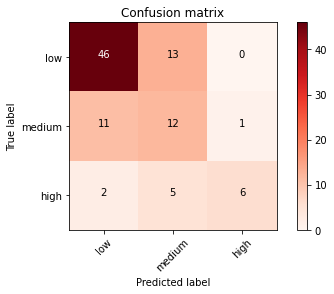

In [30]:
from OpenFabLibrary import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_val, predicted_labels)
cm_plot_labels = ['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

## Free test here

In [ ]:
#Classifying random sentences
tests = getPrediction(['其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
                       '帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
                       '還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
                       '群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-80


INFO:tensorflow:Restoring parameters from model/model.ckpt-80


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
tests

[('其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
  array([-2.455091  , -1.3244265 , -0.43357265], dtype=float32),
  2,
  'high'),
 ('帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
  array([-1.324    , -0.7256511, -1.3866073], dtype=float32),
  1,
  'medium'),
 ('還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
  array([-1.1450806, -0.6767058, -1.7515025], dtype=float32),
  1,
  'medium'),
 ('群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 ',
  array([-0.08778379, -2.7265542 , -3.9847727 ], dtype=float32),
  0,
  'low')]

Reference: https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/